<a href="https://colab.research.google.com/github/gyunini/Pytorch_Practice/blob/main/2_Basic_Model_Training(2_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CH2. Basic Model Training

Pytorch를 이용하여 인공신경망을 구축하고 학습하기 위해 먼저 데이터셋을 구축하고 Transform과 Dataloader를 통해 인공지능 모델에 데이터를 학습하기전까지의 과정을 살펴봤습니다. 이번에는 간략하게 인공지능 모델을 직접 구축해보고 학습시킨 후 모델을 저장하고 로드시키는 기본적인 모델 학습을 수행하겠습니다.


---

**Contents**
1. [Build Model](#scrollTo=jmgG75BPvzkZ)
2. [Autograd](#scrollTo=f9hQmS1sF3m2)
3. [Optimization](#scrollTo=HOlLjKPqRuaB)
4. [Save & Load Model](#scrollTo=9dlAEoJhPd_U)
5. [Transfer Learning](#scrollTo=bJCF3KYjjjv9)

**Reference**
<div align="left">
    <a href="https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html">
        <img src="https://drive.google.com/uc?id=1SwxpnRc2AHWFh4VcRZR6cYjRSRf20I2i" width="15%" alt=""/></a>
    <a href="https://timm.fast.ai/">
        <img src="https://drive.google.com/uc?id=14ZCiN9uDDKQFbrlc089j2ebdoF4hh8E8" width="15%" alt=""/></a>
</div>

# 1. Build Model

PyTorch에서는 `torch.nn` 에서 신경망을 구성하는데 필요한 모든 구성 요소를 제공합니다. 신경망은 데이터에 대한 연산을 수행하는 계층(layer), 모듈(module)로 구성되어있으며 PyTorch의 모든 모듈은 nn.Module의 하위 클래스(subclass)입니다. 신경망은 다른 모듈(레이어)로 구성된 모듈 자체로 이러한 중첩된 구조를 통해 복잡한 아키텍처를 쉽게 구축하고 관리할 수 있게 도와줍니다.

## 1.1 Get Device for Training
Pytorch를 사용하여 모델을 구축하고 학습할때 `torch.cuda.is_available()`을 사용하여 GPU와 같은 하드웨어 가속기가 존재할때 GPU를 사용하고 그렇지 않으면 CPU를 사용합니다. 본 실습에서는 GPU환경을 이용하기 위해서 Colab을 이용하여 실습을 진행합니다.

Colab에서는 간단하게 런타임 유형을 변경하여 GPU를 사용할 수 있습니다.

1. 좌측 상단의 런타임을 클릭합니다.
<div align="left">
        <img src="https://drive.google.com/uc?id=1qurh5FIuufgo0cwRvlhr9BJcpaEt9xj1" width="70%" alt=""/>
</div>        

2. 런타임 하위항목중에서 런타임 유형변경을 클릭합니다.
<div align="left">
        <img src="https://drive.google.com/uc?id=1IlFbzxl6BG_tTYAUfb6LoeLLk7dK15hJ" width="30%" alt=""/>
</div>

3. 하드웨어가속기에서 GPU를 선택한 후 저장을 클릭합니다.
<div align="left">
        <img src="https://drive.google.com/uc?id=1beHeTjN5shB-_BJCM8wwtRK1UdaFaQOG" width="35%" alt=""/>
</div>


In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## 1.2 Define the Class
신경망 모델을 `nn.Module`의 하위클래스(subclass)로 정의하고, `__init__`에서 신경망 계층을 초기화합니다. `nn.Module`을 상속받은 모든 클래스는 `forward` 메소드에 입력 데이터에 대한 연산들을 구현합니다.

간단한 선형 모델을 구현해보겠습니다.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__() #  super(파생클래스, self).__init__() 을 해준다, super()로 기반 클래스(부모 클래스)를 초기화해줌으로써, 기반 클래스의 속성을 subclass가 받아오도록 한다. (초기화를 하지 않으면, 부모 클래스의 속성을 사용할 수 없음)
        self.flatten = nn.Flatten() # flatten으로 28*28을 flatten 시켜줌 -> [1, 784] : 이차원임을 주의
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), # 28x28: FansionMNIST HxW
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

모델 클래스를 구성하고나서 모델에 하드웨어 가속기에서 모델을 학습하기 위해서 위애서 모델의 인스턴스(instance)를 생성하고 정의한 device로 모델을 설정해줍니다.

In [ ]:
# https://blog.naver.com/myincizor/221695230509
# GPU에서 학습하고 저장된 모델을 GPU에서 불러올 때는, 초기화된 모델에 ``model.to(torch.device(〈cuda〉))``을 호출하여 CUDA에 최적화된 모델로 변환 / CPU에 올라가 있는 모델을 GPU에 맞게 변환해줌
model = NeuralNetwork().to(device) # 하드웨어 가속기 사용하기 위해 인스턴스.to(device) 로 모델 생성
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


모델을 사용하기 위해서 입력데이터를 모델에 전달하는데 직접적으로 `model.forward()`를 사용하는 것이 아니라 모델에 `model(input_data)`의 형식으로 입력데이터를 모델에 전달할 수 있다.

FashionMNIST와 shape이 같은 임의의 데이터를 만들어 모델에 입력데이터로 넣은후 모델을 거쳐 `nn.Softmax` 모듈을 통해 예측확률값을 얻을 수 있습니다.

In [ ]:
X = torch.rand(1, 28, 28, device=device) # device 적용,  torch.rand: 0과 1 사이의 실수[0, 1) 로 난수를 생성 / torch.randn: 정규분포로 난수 생성
logits = model(X)
print(logits)
pred_probab = nn.Softmax(dim=1)(logits) # dim=1을 기준으로 softmax를 구하겠다
y_pred = pred_probab.argmax(1) # 인덱스
print(f"Predicted class: {y_pred}")

tensor([[-0.0219, -0.0279,  0.0278,  0.0141, -0.1181, -0.1187, -0.0102, -0.0071,
         -0.0646,  0.1499]], device='cuda:0', grad_fn=<AddmmBackward0>)
Predicted class: tensor([9], device='cuda:0')


## 1.3 Model Layer
앞에서 사용한 FashionMNIST 모델의 계층들을 살펴보기 위해서 28x28 크기의 이미지가 3개로 구성된 미니배치를 가정했을때 각 계층을 통과하면서 이미지데이터가 어떻게 변하는지 확인해보겠습니다.

In [ ]:
input_image = torch.rand(3, 28, 28)
print(input_image.size())

torch.Size([3, 28, 28])


**nn.Flatten**

`Flatten` layer는 입력데이터의 형태를 펼쳐주는 모듈로 28x28의 hxw형식의 데이터 형태를 1 x (hxw) 로 1x784 의 형태로 바꾸어줍니다. 이때 미니배치의 차원은 유지됩니다.

In [ ]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size()) # 배치의 차원은 유지됨 (채널)

torch.Size([3, 784])


**nn.Linear**

`Linear` layer는 저장된 가중치(weight)와 편향(bais)를 사용하여 입력 데이터에 선형 변환(linear transformation)을 적용하는 모듈입니다.

In [ ]:
layer1 = nn.Linear(in_features=28*28, out_features=512)
hidden1 = layer1(flat_image) # layer1(인풋) 의 형태로 실행
print(hidden1.size()) # 784를 512로 만듬

torch.Size([3, 512])


**nn.ReLU**

`ReLU` layer는 비선형 활성화 모듈로 선형 변환후에 적용되어 비선형성(nonlinearity을 도입하고 신경망이 다양한 학습을 할 수 있도록 도와줍니다.
ReLU는 입력데이터의 음수부분을 0으로 만들고 양수부분의 값은 그대로 취해서 비선형성을 추가해줍니다.

<div align="left">
        <img src="https://drive.google.com/uc?id=1ItVyF5vHuFP2R6WpWBKfLVGv8zO0M8er" width="40%" alt=""/>
</div>

In [ ]:
print(f"Before ReLU: {hidden1}\n\\n")
hidden1 = nn.ReLU()(hidden1) # 사용방법 주의: nn.ReLU()(input)
print(f"After ReLU: {hidden1}") # 음수는 0으로 변환됨

Before ReLU: tensor([[-0.2475, -0.4830,  0.3948,  ...,  0.0716, -0.0299, -0.0626],
        [-0.2335, -0.6326,  0.2698,  ..., -0.4471,  0.1108, -0.0785],
        [-0.1059, -0.7158,  0.0553,  ..., -0.3606, -0.3671,  0.1047]],
       grad_fn=<AddmmBackward0>)
\n
After ReLU: tensor([[0.0000, 0.0000, 0.3948,  ..., 0.0716, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2698,  ..., 0.0000, 0.1108, 0.0000],
        [0.0000, 0.0000, 0.0553,  ..., 0.0000, 0.0000, 0.1047]],
       grad_fn=<ReluBackward0>)


**nn.Sequential**

`Sequential`은 순서를 갖는 모듈의 컨테이너 입니다. 데이터는 정의된 것과 같은 순서로 모든 모듈을 통해 전달됩니다. 순차 컨테이너(sequential container)를 사용하여 `seq_module`와 같은 네트워크를 빠르게 만들수 있습니다.

In [ ]:
seq_modules = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 512),
    nn.ReLU(),
    nn.Linear(512,10)
)
logits = seq_modules(input_image)

**nn.Softmax**

신경망의 마지막 선형 계층에서는 모델의 클래스수만큼의 값을 출력하게 하여 그 값을 통해 모델의 각 클래스에 대한 예측 확률을 나타내도록 `nn.Softmax` 모듈을 사용합니다. 확률이기 떄문에 [0,1]범위로 비례하여 조정됩니다.


In [ ]:
softmax = nn.Softmax(dim=1) # dim 1을 기준으로 적용했기 때문에 각 행을 더하면 1이 됨
pred_probab = softmax(logits) # 역시 nn.Softmax()(인풋) 의 형태로 실행
print(pred_probab)

tensor([[0.1020, 0.0809, 0.1085, 0.1041, 0.1205, 0.0838, 0.1081, 0.0829, 0.0999,
         0.1094],
        [0.1009, 0.0914, 0.1030, 0.0957, 0.1283, 0.0870, 0.1057, 0.0808, 0.1174,
         0.0898],
        [0.0913, 0.1053, 0.1101, 0.0973, 0.1241, 0.0902, 0.1096, 0.0730, 0.1002,
         0.0990]], grad_fn=<SoftmaxBackward0>)


## 1.4 Model Parameter

신경망 내부의 많은 계층들은 매개변수화(parameterized)됩니다. 즉, 학습 중에 최적화되는 가중치(weight)와 편향(bais)과 연관되어 지는데 `nn.Module`을 상속하여 하위 클래스(subclass)를 작성하면 모델 객체 내부의 모든 필드들이 자동으로 추적(track)되며, 모델의 `parameters()` 및 `named_parameters()` 메소드로 모든 매개변수에 접근할 수 있게 됩니다. 앞서 구성한 모델의 매개변수들을 순회하며, 매개변수의 크기와 값을 출력해보겠습니다.

In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():    # named_parameters(), parameters() 로 매개변수 접근 가능
    print(f"Layer: {name} | Size: {param.size()} | Values: {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values: tensor([[ 0.0122,  0.0178,  0.0347,  ..., -0.0161, -0.0067, -0.0258],
        [-0.0051, -0.0260,  0.0311,  ...,  0.0125, -0.0081, -0.0018]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values: tensor([-0.0099, -0.0108], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values: tensor([[ 0.0236,  0.0165, -0.0352,  ..., -0.0334, -0.0048,  0.0324],
        [ 0.0254,  0.0361,  0.0330,  ...,  0.0100,  0.0320,  0.0088]],
       device='cuda:0', grad_fn=<Slice

In [ ]:
model.parameters()

<generator object Module.parameters at 0x7f1b163e4f90>

# 2. Autograd
신경망을 학습할때 가장 자주 사용되는 알고리즘은 역전파(backpropagation)입니다. 이 알고리즘에서 매개변수(모델 가중치)는 주어진 매개변수에 대한 손실 함수의 변화도(gradient)에 따라 조정됩니다.

이러한 변화도를 계산하기 위해서 PyTorch에서는 `torch.autograd`라 불리는 자동 미분 엔진이 내장되어 있어 `backward`를 `nn.Module`에 따로 작성하지 않더라도 모든 계산 그래프에 대한 변화도의 자동 계산을 지원합니다.

입력 `x`, 매개변수 `w`와 `b`, 그리고 일부 손실함수가 있는 가장 간단한 단일 계층 신경망을 가정해서 확인해보겠습니다.

autograd 살펴보기 참고 자료 : https://gaussian37.github.io/dl-pytorch-gradient/

In [ ]:
import torch
x = torch.ones(5)  # input tensor [1,1,1,1,1]
y = torch.zeros(3)  # expected output [0,0,0]
w = torch.randn(5, 3, requires_grad=True) # requires_grad=True로 해서 미분의 대상의 지정
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b # (3,)
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

### 2.1 Tensors, Functions and Computational graph
위에서 작성한 코드는 다음의 계산 그래프를 정의합니다.
<div align="left">
        <img src="https://drive.google.com/uc?id=1wsU7wmdAx-fVtln7qx_jDEbpLfDXUZpQ" width="70%" alt=""/>
</div>

이 신경망에서, `w`와 `b`는 최적화를 해야하는 매개변수로 이러한 변수들에 대한 손실 함수의 변화도를 계산할수 있어야하는데 이를 위해 해당 텐서에 `requires_grad`속성을 설정합니다. `requires_grad`의 값은 텐서를 생성할 때 설정하거나, 이후에 `x.requires_grad_(True)` 메소드를 사용해서 설정할 수 있습니다.

연산 그래프를 구성하기 위해 텐서에 적용하는 함수는 `torch.autograd.Function` 클래스의 객체로 이 객체는 순전파(Forward) 방향으로 함수를 계산하는 방법과, 역전파(backward) 단계에서 도함수(derivative)를 계산해 줍니다. 역방향 전파 함수에 대한 참조(reference)는 텐서의 `grad_fn`속성에 저장됩니다.


In [ ]:
print(f"Gradient function for z = {z.grad_fn}") # z가 x*w + b 이므로 어떤 연산을 했는지를 grad_fn이 담고 있음
print(f"Gradient function for loss = {loss.grad_fn}")
# 만약 requires_grad가 없는 텐서에서 속성을 추가할 때에는 y.requires_grad_(True)와 같은 방식으로 속성값을 추가해주면 됩니다.
# 다만, 이렇게 별도로 requires_grad를 추가한 경우 앞에서 연산한 이력이 grad_fn으로 자동으로 저장되지는 않습니다.

Gradient function for z = <AddBackward0 object at 0x7f1b4aefe2f0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f1b4aefe680>


## 2.2 Computing Gradients

신경망에서 매개변수의 가중치를 최적화하려면 매개변수에 대한 손실함수의 도함수(derivative)를 계산해야합ㄴ디ㅏ. 즉 `x`와 `y`의 일부 고정값에서 $\frac {σloss}{σw}$ 와 $\frac {σloss}{σb}$ 가 필요합니다. 이러한 도함수를 계산하기 위해서, `loss.backward()`를 호출한 다음 `w.grad`와 `b.grad`에서 값을 가져옵니다.

In [ ]:
loss.backward() # tensor의 gradient를 구하는 방법은 backpropagation을 시작할 지점의 tensor(scalar 형태)에서 .backward() 함수를 호출
print(w.grad) # loss를 w에 대해 편미분 한 값을 확인하는 법: .grad로 확인
print(b.grad)

tensor([[0.0072, 0.3153, 0.0093],
        [0.0072, 0.3153, 0.0093],
        [0.0072, 0.3153, 0.0093],
        [0.0072, 0.3153, 0.0093],
        [0.0072, 0.3153, 0.0093]])
tensor([0.0072, 0.3153, 0.0093])


### 2.2.1 Simple Example 1.
autograd로 값을 나타내는것을 확인했는데 그래프로 autograd가 실제로 어떻게 작용되는지 간단한 예를 통해서 확인해보겠습니다.

In [ ]:
# %matplotlib inline

import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

In [ ]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True) # linearly spaced vector: start, end, step https://aigong.tistory.com/596
print(a) # 25개 생성됨

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)


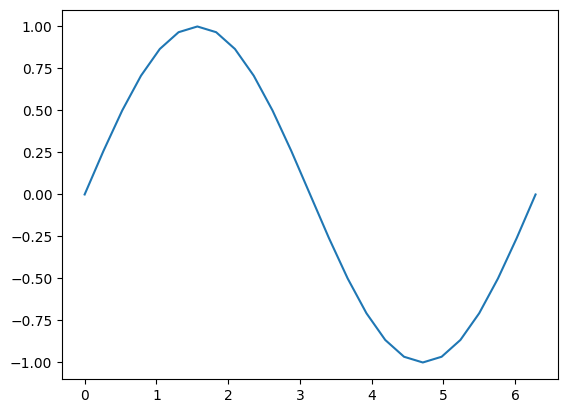

In [ ]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach()) # Tensor가 기록을 추적하는 것을 중단하게 하려면, .detach()를 호출하여 연산 기록으로부터 분리(detach)하여 이후 연산들이 추적되는 것을 방지할 수 있습니다

In [ ]:
print(b)

tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       grad_fn=<SinBackward0>)


위의 `print(b)`에서 `grad_fn=<SinBackward0>`로 표기가 되어있는데 계산 그래프와 역전파에 대해 도함수에 대한 힌트를 줍니다. 여기서는 모든 텐서의 입력값이 $sin(x)$의 도함수로 계산해야함을 알 수 있습니다. 다른 연산을 추가해서 살펴보면 `grad_fn`이 바뀌는 것을 확인할 수 있습니다.

In [ ]:
c = 2 * b
print(c)

d = c + 1
print(d)

out = d.sum()
print(out)

tensor([ 0.0000e+00,  5.1764e-01,  1.0000e+00,  1.4142e+00,  1.7321e+00,
         1.9319e+00,  2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,
         1.0000e+00,  5.1764e-01, -1.7485e-07, -5.1764e-01, -1.0000e+00,
        -1.4142e+00, -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00,
        -1.7321e+00, -1.4142e+00, -1.0000e+00, -5.1764e-01,  3.4969e-07],
       grad_fn=<MulBackward0>)
tensor([ 1.0000e+00,  1.5176e+00,  2.0000e+00,  2.4142e+00,  2.7321e+00,
         2.9319e+00,  3.0000e+00,  2.9319e+00,  2.7321e+00,  2.4142e+00,
         2.0000e+00,  1.5176e+00,  1.0000e+00,  4.8236e-01, -3.5763e-07,
        -4.1421e-01, -7.3205e-01, -9.3185e-01, -1.0000e+00, -9.3185e-01,
        -7.3205e-01, -4.1421e-01,  4.7684e-07,  4.8236e-01,  1.0000e+00],
       grad_fn=<AddBackward0>)
tensor(25., grad_fn=<SumBackward0>)


또한 `grad_fn`텐서와 함께 저장된 각 항목을 사용하면 `next_functions`속성이 있는 입력까지 계산을 다시 수행할 수 있습니다.

In [ ]:
print('d:')
print(d.grad_fn)
print(d.grad_fn.next_functions)
print(d.grad_fn.next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print('\nc:')
print(c.grad_fn)
print('\nb:')
print(b.grad_fn)
print('\na:')
print(a.grad_fn)

'''
위의 코드에서 d에 있는 grad_fn와 next_functions 프로퍼티를 사용하여 이전의 모든 텐서에 대한 gradient function을 보여주고 있습니다. 여기서 a.grad_fn은 None인데, 이는 a는 input이기 때문에 연산 기록이 없기 때문입니다.

이제 output에 대해서 backward() 메소드를 호출하면, gradients를 계산할 수 있고, input의 grad 프로퍼티를 통해 gradients의 계산값이 어떻게 되는지 살펴볼 수 있습니다.
'''

d:
((<MulBackward0 object at 0x7f1b434ce620>, 0), (None, 0))
((<SinBackward0 object at 0x7f1b434ce650>, 0), (None, 0))
((<AccumulateGrad object at 0x7f1b434cf070>, 0),)
()

c:

b:

a:
None


위에서 정의한 `out`의 gardient를 그래프로 표현해서 실제로 미분이 되었는지를 살펴보려고한다. 이전의 `out`이 만들어진 단계를 다시 한번 살펴보면
```python
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True
b = torch.sin(a)
c = 2 * b
d = c + 1
out = d.sum()
```
으로 상수를 더하는 것으로 미분에 의한 계산그래프는 변화하지 않는다(`d`). **$ c = 2 * b = 2 * sin(a)$** 에서 미분을 하게되면 **$2 * cos(a)$**로 변하게되는데 실제로 out의 backward의 그래프를 확인했을때 미분이 진행된 것을 확인할 수 있다.

tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


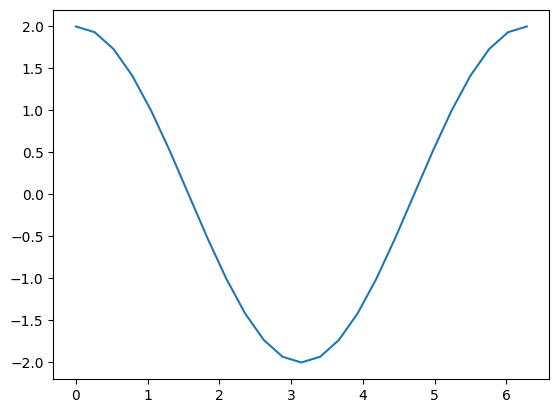

In [ ]:
out.backward()
print(a.grad)
plt.plot(a.detach(), a.grad.detach()) # sin 미분하면 cos을 그림으로 확인 가능

### 2.2.2 Simple Example 2.

이번에는 `torch.autograd.Function`으로 사용자 정의 함수를 만들어서 backward가 제대로 수행되는지 확인해보겠습니다.

앞서 신경망을 만들때는 `torch.nn`의 모듈을 상속받는 하위 클래스(sub class)로 작성하였는데 사용자 정의 함수도 마찬가지로 상위 클래스를 상속받아서 작성합니다. 사용자 정의 함수를 만들려면 `torch.autograd.Function`을 상속받는 하위 클래스(subclass)에서 `forward()`와 `backward()` 메소드를 구현하여 작성합니다. 그 후에 작성한 함수를 사용할때는 torch에서 구현되어있는 함수를 사용할때와는 다르게 `apply` 메소드를 이용하여 연산을 작동시킵니다.

이번 예제에서는 앞서 [1.3장](#scrollTo=k5yYpUZC9jn_) 에서 설명한 ReLU 함수를 직접 만들어서 위의 예제에 추가하여 시각적으로 확인해보겠습니다.

In [ ]:
import torch
from torch.autograd import Function # torch.autograd.Function

class ReLU(Function): # 사용자 정의 함수이기 때문에 Function 상속 후 forward, backward 오버라이딩
    # static method 공부하기: https://dojang.io/mod/page/view.php?id=2379#google_vignette
    @staticmethod # 클래스에서 바로 메서드 호출 가능, 정적 메서드는 self를 받지 않으므로 인스턴스 속성에는 접근할 수 없습니다. 그래서 보통 정적 메서드는 인스턴스 속성, 인스턴스 메서드가 필요 없을 때 사용합니다.
    def forward(ctx, input):
        """
        순전파 단계에서는 입력을 갖는 텐서를 받아 출력을 갖는 텐서를 반환합니다.
        *** ctx는 컨텍스트 객체(context object)로 역전파 연산을 위한 정보 저장에 사용합니다.
        ctx.save_for_backward 메소드를 사용하여 역전파 단계에서 사용할 어떤 객체도
        저장(cache)해 둘 수 있습니다.
        """
        output = input.clamp(min=0) # 최소가 0이 되도록 그 이하의 값을 교체 즉 마이너스 값이 있으면 얘네들을 0이 되도록 교체함
        ctx.save_for_backward(input) # TORCH.AUTOGRAD.FUNCTION.FUNCTIONCTX.SAVE_FOR_BACKWARD https://pytorch.org/docs/stable/generated/torch.autograd.function.FunctionCtx.save_for_backward.html
        return output

    @staticmethod
    def backward(ctx, grad_output):
        """
        역전파 단계에서는 출력에 대한 손실(loss)의 변화도(gradient)를 갖는 텐서를 받고,
        입력에 대한 손실의 변화도를 계산해야 합니다.
        grad_output : 목적함수의 기울기
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone() # 텐서 복사
        grad_input = grad_input * (input > 0).float() # 0보다 작으면 기울기가 0이므로 큰 것만 계산 , 목적함수의 기울기를 곱해줘야됨(upstream gradient이므로)
        return grad_input, None

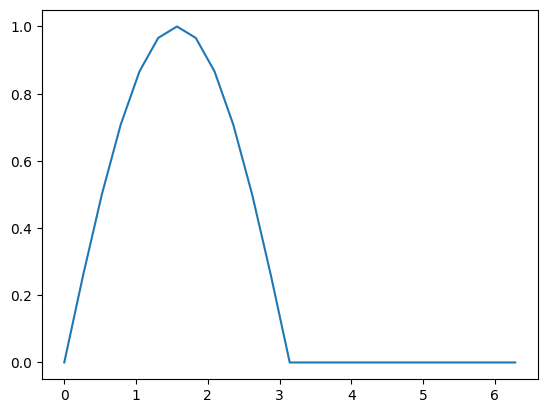

In [ ]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True) # 0~ 2pi 까지 25개 생성
b = torch.sin(a)
c = ReLU.apply(b) # apply를 이용하여 forward 실행
plt.plot(a.detach(), c.detach())

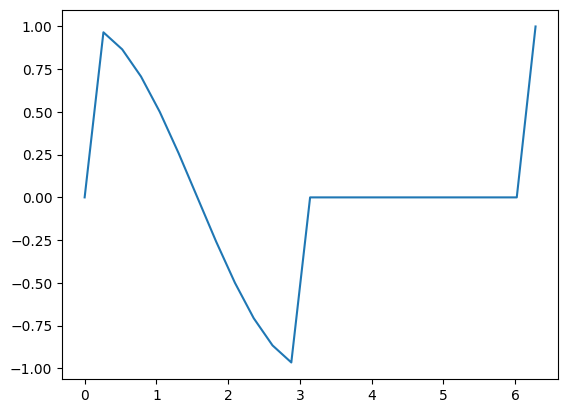

In [ ]:
out = c.sum()
out.backward()
plt.plot(a.detach(), a.grad.detach())

우리가 직접 만든 ReLU함수가 과연 제대로 구현되었는지 `torch.nn.ReLU`와 비교해보겠습니다. 비교 결과 직접 `torch.autograd.Function`을 상속 받아 만든 ReLU함수가 `torch.nn.ReLU`를 사용한 결과와 동일하게 나온것을 확인할 수 있습니다.

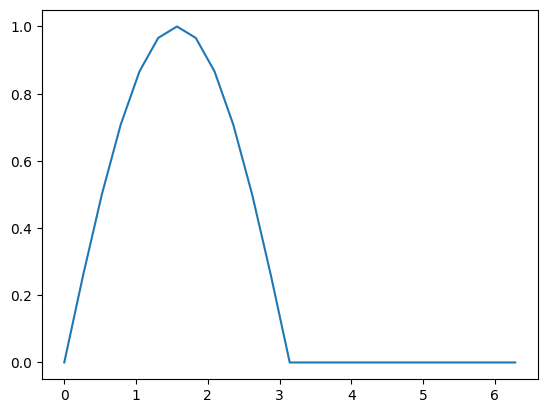

In [ ]:
ReLU = torch.nn.ReLU()
a2 = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
b2 = torch.sin(a2)
c2 = ReLU(b2)
plt.plot(a2.detach(), c2.detach())

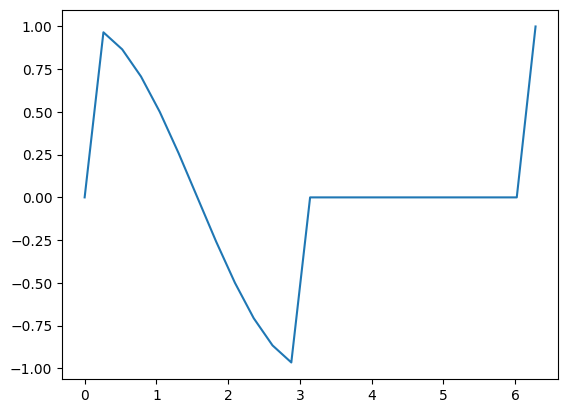

In [ ]:
out2 = c2.sum()
out2.backward()
plt.plot(a2.detach(), a2.grad.detach())

## 2.3 Disabling Gradient Tracking
Pytorch에서는 기본적으로 `requires_grad=True`인 모든 텐서들은 연산 기록을 추적하고 gradient 계산을 지원합니다. 그러나 모델을 학습한 뒤에 학습한 모델을 검증할때와 같이 단순히 순전파(forward)연산만 필요한 경우 gradient를 더 이상 수행하지않아야 하는 경우가 있습니다. 이러한 경우 연산 코드를 `torch.no_grad()` 블록으로 둘러싸거나 `detach()`메소드를 사용하여 `torch.autograd`의 연산 추적을 멈출 수 있습니다.

이러한 gradeint tracking을 멈춰야 하는 이유는 다음과 같습니다.
* 일반적으로 사전 학습된(pretrained) 신경망을 미세조정할때 일반적으로 신경망의 일부 매개변수를 고정된 매개변수(frozen parameter)로 표시
* gradeint tracking을 하지 않음으로 텐서 연산이 forward 단계만 수행하기 때문에 연산 속도가 향상됨


In [ ]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b

print(z.requires_grad)

# with문 이해: https://velog.io/@hyungraelee/Python-with
with torch.no_grad(): # torch.no_grad()로 설정 pytorch의 autograd engine을 비활성화 시킨다. 즉, 더이상 gradient를 트래킹하지 않는다. 따라서 필요한 메모리가 줄어들고 계산속도가 증가한다.
    z = torch.matmul(x, w) + b
print(z.requires_grad)

z.requires_grad = True
print(z.requires_grad)

z = z.detach()
print(z.requires_grad)

True
False
True
False


## 2.4 More on Computational Graphs
Autograd는 `torch.autograd.Function` 개체로 구성된 방향성 비순환 그래프(DAG: Directed Acyclic Graph)에 데이터(텐서) 및 실행된 모든 연산들(연산 결과로 인해 생성되는 새로운 텐서도 포함)의 기록을 저장합니다. 이 방향성 비순환 그래프(DAG)의 잎 노드(leave)의 input 텐서이고 루트(root)는 output 텐서입니다. 이 그래프를 루트에서부터 잎까지 추적하면 연쇄법칙(chain rule)에 따라 gradient를 자동으로 계산할 수 있습니다.

forward 단계에서 autograd는 두가지 작업을 동시에 수행합니다.
- 텐서를 계산하기 위해서 요청된 연산을 수행하고
- 방향성 비순환 그래프(DAG)에 gradient function의 기능을 유지합니다.

역전파 단계에서는 방향성 비순환 그래프(DAG)의 루트(root)에서 `.backward()`가 호출될 때 시작됩니다. 이때 autograd의 역할은
- 각각의 `.grad_fn`으로 부터 gradient를 계산하고
- 각각의 텐서의 `.grad`속성에 계산한 gradient를 계산한 결과를 축적하고
- 연쇄법칙(chain rule)를 사용하여 모든 잎(leaf)텐서들까지 전파(propagate)해줍니다.

## 2.5 Optional Reading: Tensor Gradients and Jacobian Products


대부분의 경우, 스칼라 손실 함수를 가지고 일부 매개변수와 관련한 변화도를 계산해야 합니다.
그러나 출력 함수가 임의의 텐서인 경우가 있습니다. 이럴 때, PyTorch는 실제 변화도가 아닌
**야코비안 곱(Jacobian product)** 을 계산합니다.

$\vec{x}=\langle x_1,\dots,x_n\rangle$ 이고,
$\vec{y}=\langle y_1,\dots,y_m\rangle$ 일 때
벡터 함수 $\vec{y}=f(\vec{x})$ 에서 $\vec{x}$ 에 대한
$\vec{y}$ 의 변화도는 **야코비안 행렬(Jacobian matrix)** 로 주어집니다:

\begin{align}J=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\end{align}

야코비안 행렬 자체를 계산하는 대신, PyTorch는 주어진 입력 벡터 $v=(v_1 \dots v_m)$ 에 대한
**야코비안 곱(Jacobian Product)**  $v^T\cdot J$ 을 계산합니다.
이 과정은 $v$ 를 인자로 ``backward`` 를 호출하면 이뤄집니다. $v$ 의 크기는
곱(product)을 계산하려고 하는 원래 텐서의 크기와 같아야 합니다.

https://angeloyeo.github.io/2020/07/24/Jacobian.html

In [ ]:
inp = torch.eye(5, requires_grad=True) # 대각선만 1인 행렬
out = (inp+1).pow(2)
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"\nSecond call\n{inp.grad}") # gradient 누적됨****
inp.grad.zero_()
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.],
        [4., 4., 4., 4., 8.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])



동일한 인자에 `backward`를 두 차례 호출했을때 gradeint 값이 다르게 나타는데 이는 PyTorch에서 gradient를 누적해주기 때문이다. 즉, `backward`를 수행할때 계산된 gradient의 값이 계산그래프의 잎(leaf) 노드의 `grad`속성에 추가되기 때문에 두 차례 호출되었을때 gradient의 값이 다르게 나타난다. 따라서 제대로된 gradient를 계산하기 위해서는 먼저 `grad`속성을 0으로 만들어줘야한다. 실제로 학습할때에는 이러한 과정을 optimizer가 도와준다.

## 3. Optimization
앞에서 데이터를 구축하는 것과 모델을 구축하는 것에 대해 배웠습니다. 이제 데이터와 모델이 준비되었으니 데이터에 매개변수를 최적화하여 모델을 훈련, 검증 및 테스트를 해야합니다. 모델의 학습은 반복적인 프로세스를 통해서 이루어지는데 이러한 반복의 과정을 `epoch`으로 부르며 각 반복되는 단계에서 모델은 output을 추측하여 예측값을 출력하고 실제 정답 사이의 loss(손실함수)를 계산하고, 매개변수에 대한 도함수(derivative)를 수집한 뒤, 경사하강법과 같은 optimizer를 사용하여 파리미터들을 최적화 해줍니다.

우선 이전까지 실습했던 FashionMNIST 코드를 다 불러오겠습니다.

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

100%|██████████| 26421880/26421880 [00:02<00:00, 10364036.35it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 174433.68it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3170634.87it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6072068.90it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
train_dataloader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
for i, (x, y) in enumerate(train_dataloader): # dataloader은 iterable한 객체
  if i == 1:
    print(i)
    print(x, y)
    print(x.shape, y.shape) # torch.Size([64, 1, 28, 28]) torch.Size([64])

1
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  

## 3.1 Hyperparameters
하이퍼파라미터(Hyperparameter)는 모델 최적화 과정을 제어할 수 있는 조절 가능한 매개변수입니다. 서로 다른 하이퍼파라미터 값은 모델 학습과 수렴율(convergence rate)에 영향을 미칠 수 있습니다.

이번 실습에서 학습할때 사용하는 하이퍼파라미터는 다음과 같습니다.
```python
learning_rate = 1e-3
batch_size = 64
epochs = 5
```


- Number of Epochs: 데이터셋을 반복하는 횟수
- Batch Size: 매개변수가 갱신되기 전 신경망을 통해 전파된 데이터 샘플의 갯수
- Learning Rate: 각 batch/epoch에서 모델의 매개변수를 조절하는 비율로 값이 작을수록 학습 속도가 느려지고, 값이 크면 학습 중 예측할 수 없는 동작이 발생할 수 있습니다.



In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

## 3.2 Optimization Loop
하이퍼파라미터를 설정한 뒤에는 최적화 단계를 통해 모델을 학습하고 최적화 할 수 있습니다. 최적화 단계의 각 반복(iteration)을 에폭(Epoch)이라고 부릅니다.

하나의 에폭에는 두개의 파트로 구성되는데
1. The Train Loop: 학습용 데이터셋을 반복(iterate)하고 최적의 매개변수로 수렴
2. The Validation/Test Loop: 모델 성능이 개선되고 있는지 파악하기 위해서 테스트 데이터셋을 반복합니다.

최적화 코드를 반복하여 수행하는 `train_loop`와 테스트 데이터로 모델의 성능을 측정하는 `test_loop`를 살펴보겠습니다.

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad() # optimizer.zero_grad() : 이전의 gradient값이 지금의 gradient값에 영향을 주지 않게 하기 위해서사용함 ⇒ 이전 에폭에서 backward를 통해 얻은 .grad값이 이번 에폭에 영향을 주지 않게 하는 것
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]") # > 로 정렬, 길이 7자리 소수점


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader) # 배치 크기 64 였음
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## 3.3 Loss Function
일부 학습용 데이터가 제공되면 훈련되지 않은 네트워크는 정답을 제대로 예측하지 못할 확률이 높습니다. 손실 함수(Loss function)은 모델이 예측한 결과와 실제 정답 값 사이의 틀린 정도(degree of dissimilarity)를 측정하며, 학습 중에 이 값을 최소화하려고 합니다. 주어진 데이터 샘플을 입력으로 계산한 예측과 정답(label)을 비교하여 손실값(loss)을 계산합니다.

일반적으로 손실함수에는 회귀(regression) 문제에 사용하는 평균제곱오차(MSE: Mean Square Error)나 분류(classification)에 사용하는 음의 로그 우도(NLL: Negative Log Likelihood))또는 소프트맥스 함수와 NLL함수를 합친 CrossEntropyLoss 등이 있습니다.

Pytorch에서는 다양한 손실 함수들을 `torch.nn`나 `torch.nn.functional`에서 불러와 사용할 수 있습니다. 이 두 방식의 차이는 `torch.nn.functional`은 함수로 구성되어 있고 `torch.nn`은 클래스로 정의되어 있는데 결과적으로 두 방식 다 같은 결과를 제공하고 둘 중에 편한것으로 선택해서 활용하면됩니다.

<div align="left">
    <a href="https://pytorch.org/docs/stable/nn.html#loss-functions">
        <img src="https://drive.google.com/uc?id=14i-ycHuwGCTNv_jd1K4lAi_0llAf7kjH" width="45%" alt=""/></a>
    <a href="https://pytorch.org/docs/stable/nn.functional.html#loss-functions">
        <img src="https://drive.google.com/uc?id=1644goE07a8aGB6O1eYVTGaawt3JBLcWl" width="50%" alt=""/></a>
</div>

이번 실습에서는 CrossEntropyLoss 손실함수를 사용하여 모델의 출력 로짓(logit)을 `nn.CrossEntropyLoss()`에 전달하여 로짓(logit)을 정규화하고 예측 오류를 계산합니다.

In [ ]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

## 3.4 Optimizer
최적화는 각 학습 단계에서 모델의 오류를 줄이기 위해 모델 매개변수를 조정하는 과정입니다. 확률적 경사 하강법(SGD: Stochastic Gradient Descent)와 같은 **최적화 알고리즘(optimization algorithms)**은 이 과정이 수행되는 방식을 정의합니다. Pytorch에서는 `torch.optim`에 SGD, RMSProp, ADAM등 다양한 최적화 알고리즘이 구현되어있습니다.

Optimizer를 설정한 후 모델의 학습에 적용하기 위해서 학습하려는 모델의 매개변수와 학습률(learning rate) 하이퍼파라미터를 입력하여 optimizer를 초기화합니다.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

학습 단계(loop)에서 최적화는 세단계로 이루어집니다.
1. `optimizer.zero_grad()`를 호출하여 모델 매개변수의 gradient를 재설정합니다. gradient는 기본적으로 축적되기 때문에 중복 계산을 막기 위해서 반복할때마다 명시적으로 0으로 설정합니다.
2. `loss.backwards()`를 호출하여 예측 손실(prediction loss)을 역전파(backpropagate)해 줍니다. PyTorch는 각 매개변수에 대한 loss의 gradient를 저장합니다.
3. gradient를 계산한 뒤에는 `optimizer.step()`를 호출하여 backward 단계에서 수집된 gradient로 매개변수를 조정합니다.

## 3.5 Model Training
이제 위에서 구축한 데이터셋, 모델, 손실함수, optimizer를 이용하여 학습을 진행해보겠습니다.

실습을 통해 5 epoch을 학습한 결과 `test_loop`에서 test 데이터에 대한 정확도가 64.6% 가 나왔습니다.

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300715  [    0/60000]
loss: 2.287325  [ 6400/60000]
loss: 2.272588  [12800/60000]
loss: 2.268132  [19200/60000]
loss: 2.249176  [25600/60000]
loss: 2.221644  [32000/60000]
loss: 2.229187  [38400/60000]
loss: 2.196680  [44800/60000]
loss: 2.191525  [51200/60000]
loss: 2.157974  [57600/60000]
Test Error: 
 Accuracy: 40.9%, Avg loss: 2.157242 

Epoch 2
-------------------------------
loss: 2.168448  [    0/60000]
loss: 2.151183  [ 6400/60000]
loss: 2.098900  [12800/60000]
loss: 2.112157  [19200/60000]
loss: 2.060028  [25600/60000]
loss: 2.005596  [32000/60000]
loss: 2.032467  [38400/60000]
loss: 1.957417  [44800/60000]
loss: 1.959398  [51200/60000]
loss: 1.882941  [57600/60000]
Test Error: 
 Accuracy: 55.2%, Avg loss: 1.885789 

Epoch 3
-------------------------------
loss: 1.923062  [    0/60000]
loss: 1.880254  [ 6400/60000]
loss: 1.772379  [12800/60000]
loss: 1.807239  [19200/60000]
loss: 1.692904  [25600/60000]
loss: 1.651612  [32000/600

# 4. Save & Load Model
이번 실습에서는 학습한 모델을 저장하고 로드하는 과정을 알아보겠습니다. 이번 실습에서는 간단한 모델구조와 비교적 간단한 데이터셋인 FashionMNIST를 사용하고 epoch을 5로 설정하여 학습을 수행하여 금방 완료되었지만 모델의 구조가 복잡해지거나 학습하기 더 어려운 데이터셋을 사용하거나 에폭의 수가 늘어나면 모델을 학습하는데 엄청난 시간이 소요될 수 있으며 만약 어플리케이션이나 실생활에서 활용할때 사용할 때마다 모델을 학습하여 응용한다면 시간 및 비용의 문제로 실제로 사용되기는 어려울 것입니다. 따라서 모델을 학습하고 그 결과를 저장하여 필요할때 불러들여서 효율적으로 사용할 수 있습니다.

우선 실습에서 학습한 모델을 저장하고 불러들여 테스트 데이터에서 동일한 결과가 나오는지 확인해보겠습니다.

Pytorch 모델은 학습된 매개변수를 `state_dict`라 불리는 내부 상태 사전(internal state dictionary)에 저장합니다. 이 상태 값들은 `torch.save` 메소드를 사용하여 저장할 수 있습니다.

이전에 FashionMNist 데이터셋으로 학습한 모델을 저장해보겠습니다.

In [ ]:
import torch
# save train model
torch.save(model.state_dict(), 'model_weights.pth')

저장한 모델의 결과를 검증하기위해서 데이터셋과 모델을 초기화하여 다시 정의하겠습니다.

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

초기화된 모델에 저장된 모델의 가중치를 불러오기 위해서 `load_state_dict()`메소드를 사용하여 매개변수를 불러옵니다.



In [ ]:
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

성공적으로 모델을 불러들었으면 손실함수를 정의해서 테스트데이터에 검증을 해서 모델이 제대로 저장되고 불러졌는지 확인할 수 있습니다. 확인 결과 저장하기전에 확인했던 테스트 데이터에 대한 정확도가 64.6%로 동일한 것을 알 수 있습니다.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 65.4%, Avg loss: 1.081128 



## 4.1 Pre-trained model load
위의 예제에서는 비교적 간단하며 Gray Scale인 FashionMNIST 데이터셋과 단순한 MLP(Multi-Layer perceptron)를 이용하고 에폭의 수도 5개로 학습하여 빠른시간에 모델을 학습시킬 수 있었는데 이와 다르게 Gray Scale이 아닌 RGB와 모델의 구조가 복잡해지며 에폭수도 300개 이상 늘어났을때 학습되는 시간은 매우 오래소요될 것이다.

앞서 인공지능모델을 학습하는데에는 모델이나 데이터셋 등이 복잡해 질수록 시간이 오래 소요된다고 하였는데 Pytorch나 Timm에서는 IMAGENET과 같은 대용량 데이터셋에서 학습된 모델들을 저장하여 Pytorch에서 편리하게 적용할 수 있도록 패키지화하여 배포하고 있다.

In [ ]:
# Pytroch Pre-trained model load
import torchvision
from torchvision import models
print(torchvision.__version__)

0.15.2+cu118


Pytorch에서 사용가능한 pre-trained 모델

In [ ]:
model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))
print(f"available models_num:{len(model_names)}, models{model_names}")

available models_num:85, models['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'get_model', 'get_model_builder', 'get_model_weights', 'get_weight', 'googlenet', 'inception_v3', 'list_models', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resne

Pytorch에서 pre-trained모델 load

torchvision 0.13.1 버전부터는 `model(pretrained=True)`을 사용해서 pre-tarined 모델을 불러오면 `model(weights="IMAGENET1K_V1")`과 같은 형식을 권장하며 곧 대체될 것이라는 경고매세지가 뜬다

In [ ]:
# model = models.resnet18(weights="IMAGENET1k_V2") # recommanded torchvision 0.13.1+
model = models.alexnet(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 253MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Timm에서 사용가능한 pre-trained모델


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.5 MB/s eta 0:00:00


In [ ]:
import timm
print(f"available models_num:{len(timm.list_models())}, models{timm.list_models()}")

available models_num:991, models['bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_small', 'coat_tiny', 'coatnet_0_224', 'coatnet_0_rw_224', 'coatnet_1_224', 'coatnet_1_rw_224', 'coatnet_2_224', 'coatnet_2_rw_224', 'coatnet_3_224', 'coatnet_3_rw_224', 'coatnet_4_224', 'coatnet_5_224', 'coatnet_bn_0_rw_224', 'coatnet_nano_cc_224', 'coatnet_nano_rw_224', 'coatnet_pico_rw_224', 'coatnet_rmlp_0_rw_224', 'coatnet_rmlp_1_rw2_224', 'coatnet_rmlp_1_rw_224', 'coatnet

Timm pre-trained model load

In [ ]:
model = timm.create_model('vgg16', pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 5. Transfer Learning
전이학습(Transfer Learning)이란 `한 분야의 문제를 해결하기 위해서 얻은 지식과 정보를 다른 문제를 푸는데 사용하는 방식`으로 전이 학습을 사용하면 특정 태스크를 위해 훈련된 모델을 다른 태스크에도 적용할 수 있어서 대량의 학습데이터 없이도 복잡한 신경망을 훈련할 수 있다. 실제로 충분한 크기의 데이터셋을 갖추려면 상당한 비용과 노력이 필요하기때문에 대규모 데이터셋에서 좋은 성능을 나타내는 사전훈련된 모델을 이용하여 이러한 문제를 해결할 수 있습니다.

전이학습의 주요 사용방법은 다음과 같습니다.
- Finetuning the convnet: 무작위로 초기화 하는것이 아닌 사전 훈련된 모델로 초기화 합니다.
- ConvNet as fixed feature extractor: 마지막의 fully-connected layer를 제외한 모든 신경망의 가중치를 고정하여 마지막 fully-connected layer는 새로운 무작위의 가중치를 갖는 계층으로 대체되어 이 계층만 학습합니다.

전이학습 예제는 개미와 벌을 분류하는 모델을 학습하는것인데 개미와 벌의 학습용 이미지는 대략 120장, 검증용 이미지는 75장으로 전이학습을 하지않고 처음부터 학습한다면 일반화하기에는 아주 작은 데이터셋입니다. 따라서 전이학습을 통해 일반화가 잘되는지 확인해보겠습니다.

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2023-09-11 03:31:13--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.192.150.27, 54.192.150.110, 54.192.150.31, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.150.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  79.4MB/s    in 0.6s    

2023-09-11 03:31:13 (79.4 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

'''
torch.backends.cudnn.benchmark 코드는 True와 False로 설정할 수 있다.
이 코드의 역할은 다음과 같다.
내장된 cudnn 자동 튜너를 활성화하여, 하드웨어에 맞게 사용할 최상의 알고리즘(텐서 크기나 conv 연산에 맞게?)을 찾는다.
입력 이미지 크기가 자주 변하지 않는다면, 초기 시간이 소요되지만 일반적으로 더 빠른 런타임의 효과를 볼 수 있다.
그러나, 입력 이미지 크기가 반복될 때마다 변경된다면 런타임성능이 오히려 저하될 수 있다.
'''
cudnn.benchmark = True


plt.ion()   # interactive mode 대화형 모드

### 5.1 Load Data
이번에는 Pytorch가 제공하는 데이터셋 모듈중에서 `torchvision.datasets.ImageFolder`를 이용하여 데이터셋을 구축하겠습니다. `torchvision.datasets.ImageFolder`는 아래와 같이 클래스레이블이 따로 지정되지 않고 폴더로 데이터가 구분지어져 있을때 주로 사용하며 기본적으로 아래와 같은 형식으로 정렬된 데이터에서 사용됩니다.
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/[...]/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/[...]/asd932_.png
```
이를 통해서 이미지와 라벨의 쌍을 따로 만들어 반환하는 데이터셋 클래스를 구축하지 않더라도 편리하게 데이터셋을 구축할 수 있습니다.



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), # torchvision.datasets.ImageFolder(root, transform) -> root 밑에 class명 디렉토리가 있다는 것을 알게 해줌
                                          data_transforms[x]) # https://yeko90.tistory.com/entry/pytorch-how-to-use-ImageFolder 참고
                  for x in ['train', 'val']}
print(image_datasets)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes
print(class_names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
['ants', 'bees']


### 5.2 Visualize a few images
구축된 일부 학습용 이미지를 시각화해서 확인해보겠습니다.

tensor([[[[-0.7308, -0.7822, -0.7993,  ..., -1.8097, -1.7754, -1.8782],
          [-0.6965, -0.7308, -0.7650,  ..., -1.8268, -1.7925, -1.8610],
          [-0.7308, -0.7650, -0.7822,  ..., -1.7583, -1.7240, -1.7754],
          ...,
          [-0.5596, -0.4911, -0.5082,  ..., -1.4672, -1.4158, -1.4500],
          [-0.5424, -0.5938, -0.5938,  ..., -1.5014, -1.4158, -1.4329],
          [-0.3883, -0.4054, -0.7308,  ..., -1.4500, -1.4672, -1.4158]],

         [[ 0.2927,  0.3452,  0.3277,  ..., -1.5455, -1.4930, -1.5105],
          [ 0.3277,  0.3277,  0.3102,  ..., -1.5105, -1.5105, -1.4930],
          [ 0.3102,  0.3452,  0.3277,  ..., -1.4580, -1.5455, -1.5455],
          ...,
          [ 0.0126,  0.0651,  0.1527,  ..., -0.8452, -0.8102, -0.8627],
          [ 0.0476, -0.0574, -0.1975,  ..., -0.8102, -0.8102, -0.8803],
          [ 0.0651, -0.2150, -0.5476,  ..., -0.8277, -0.8277, -0.8452]],

         [[-0.9156, -0.9156, -0.9156,  ..., -1.4733, -1.4036, -1.4559],
          [-0.8807, -0.8981, -

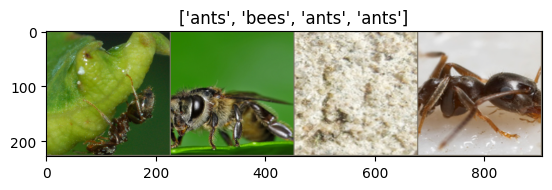

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train'])) # 배치 1개 -> 4개 이미지
print(inputs, classes)

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs) # make_grid: https://supermemi.tistory.com/entry/PyTorch-torchvision-makegrid-%EC%82%AC%EC%9A%A9%ED%95%98%EA%B8%B0

print(out.shape)

imshow(out, title=[class_names[x] for x in classes])


### 5.3 Model Training

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### 5.4 Finetuning
ImageNet으로 사전훈련된 모델의 경우 ImageNet의 class 개수인 1000개가 마지막 fully-connected layer의 output으로 구성되어있다. 우리는 벌과 개미에 대한 분류를 진행하기때문에 마지막 fully-connected layer의 output을 2개로 조정하여 초기화합니다.

여기서는 위의 계층을 freeze하지 않고 학습을 진행하겠습니다.

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 285MB/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5621 Acc: 0.7295
val Loss: 0.1594 Acc: 0.9542

Epoch 1/24
----------
train Loss: 0.4508 Acc: 0.7951
val Loss: 0.1742 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.5313 Acc: 0.7951
val Loss: 0.3656 Acc: 0.8366

Epoch 3/24
----------
train Loss: 0.3717 Acc: 0.8320
val Loss: 0.2591 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.5013 Acc: 0.8197
val Loss: 0.2771 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.4296 Acc: 0.8402
val Loss: 0.2716 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.5728 Acc: 0.7992
val Loss: 0.2073 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3535 Acc: 0.8320
val Loss: 0.1994 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3281 Acc: 0.8648
val Loss: 0.1916 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3934 Acc: 0.8279
val Loss: 0.2024 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2738 Acc: 0.8893
val Loss: 0.2056 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.3950 Acc: 0.7951
val Loss: 0.1907 Acc: 0.9150

Ep

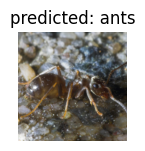

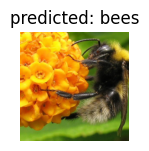

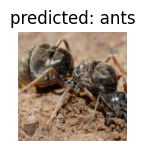

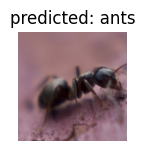

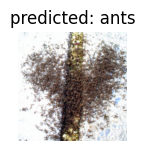

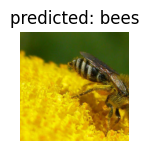

In [ ]:
visualize_model(model_ft)

### 5.5 ConvNet as fixed feature extractor
이제 마지막 fully-connected layer를 제외한 나머지 layer의 가중치를 고정(freeze)하여 학습해보겠습니다. 나머지 계층을 고정하기 위해서는 `requres_grad = False`를 이용하여 매개변수를 고정해 `backward`시에 gradient가 계산되지않게 할 수 있습니다.

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6015 Acc: 0.6639
val Loss: 0.2335 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4625 Acc: 0.7869
val Loss: 0.2295 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.5439 Acc: 0.7664
val Loss: 0.2330 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4097 Acc: 0.7951
val Loss: 0.2112 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.3757 Acc: 0.8525
val Loss: 0.2415 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.5897 Acc: 0.7664
val Loss: 0.1915 Acc: 0.9608

Epoch 6/24
----------
train Loss: 0.5437 Acc: 0.8074
val Loss: 0.1949 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.4171 Acc: 0.8197
val Loss: 0.1671 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.3632 Acc: 0.8361
val Loss: 0.1738 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.3854 Acc: 0.8361
val Loss: 0.2023 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3333 Acc: 0.8607
val Loss: 0.1768 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3635 Acc: 0.8443
val Loss: 0.1994 Acc: 0.9346

Ep

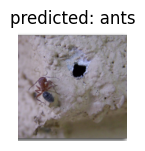

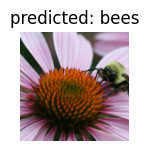

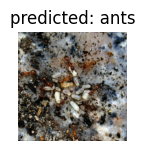

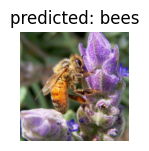

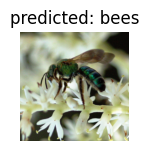

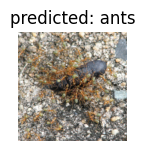

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()